In [1]:
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input, Reshape, GRU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import pandas as pd
import soundfile as sf
#from scipy.io import wavfile
#from scipy import signal

sr = 44100

# gan에 입력되는 noise에 대한 dimension
NOISE_DIM = 10 #잘 모르겠음...ㅎㅎ

# adam optimizer 정의, learning_rate = 0.0002, beta_1로 줍니다.
# Vanilla Gan과 DCGAN에서 이렇게 셋팅을 해주는데
# 이렇게 해줘야 훨씬 학습을 잘합니다.
# 그렇다고 합니다..ㅎㅎ
adam = Adam(lr=0.0002, beta_1=0.5)
mfcc_data = []

In [2]:
def load_wave_generator(path): #이전 깃헙에서 가져온 파일 읽어들이는 함수(라벨 붙이는것만 삭제)

    batch_waves = []
    stft_data = []
    temp = []
    global s_data

    folders = os.listdir(path)

    for folder in folders:
        if not os.path.isdir(path):continue #폴더가 아니면 continue
        files = os.listdir(path+"/"+folder)
        print("Foldername :",folder,"-",len(files),"files")
        #폴더 이름과 그 폴더에 속하는 파일 갯수 출력
        for wav in files:
            if not wav.endswith(".wav"):continue
            else:
                #print("Filename :",wav)#.wav 파일이 아니면 continue
                y, sr = librosa.load(path+"/"+folder+"/"+wav)
                ny = y[:sr*5]
                stft = librosa.stft(ny, n_fft=128, hop_length=128, win_length=128).T
                stft = np.abs(stft)
                
                stft_data.append(stft)
                #print("Stft Size : ", stft.shape)
                
    #end loop
    #print("X_data :",np.shape(X_data))
    s_data = stft_data
    

load_wave_generator("./data")    #일단 RYU 음성 읽어오기
stft_data = np.array(s_data)
#print(np.shape(sound_data))
stft_data.shape

Foldername : 1 - 20 files


(20,)

In [3]:
for i in range(0,19):
    print(stft_data[i].shape)
np.version.version

(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)
(862, 65)


'1.18.5'

In [4]:
"""
generator = Sequential([                 #generator 시퀀스 생성 
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(1025, activation='tanh'),
])
"""
generator = Sequential()
generator.add(Dense(512, input_dim=NOISE_DIM))
generator.add(LeakyReLU(0.2))
generator.add(Dense(8192))
generator.add(LeakyReLU(0.2))
generator.add(Dense(56030, activation='tanh'))
generator.add(Reshape((862,65), input_shape=(56030,)))

In [38]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               5632      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              4202496   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 56030)             459053790 
_________________________________________________________________
reshape (Reshape)            (None, 862, 65)           0         
Total params: 463,261,918
Trainable params: 463,261,918
Non-trainable params: 0
__________________________________________

In [39]:
"""
discriminator = Sequential([
    Dense(1024, input_shape=(1723,65), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), #relu의 개선버전
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])
"""
discriminator = Sequential()
discriminator.add(GRU(128, input_shape=(862,65)))
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dense(32, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

In [40]:
discriminator.summary()
discriminator.input

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               74880     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 85,249
Trainable params: 85,249
Non-trainable params: 0
_________________________________________________________________


<tf.Tensor 'gru_input:0' shape=(None, 862, 65) dtype=float32>

In [41]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [42]:
# discriminator는 학습을 하지 않도록 하며, Gan 모델에서는 generator만 학습하도록 합니다.
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

In [43]:
gan = Model(gan_input, output)
gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 862, 65)           463261918 
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 85249     
Total params: 463,347,167
Trainable params: 463,261,918
Non-trainable params: 85,249
_________________________________________________________________


In [44]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [45]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    #오디오 파일 듣기 추가 요망
    

In [46]:
BATCH_SIZE = 20
EPOCHS= 20

In [47]:
# discriminator와 gan 모델의 loss 측정을 위한 list 입니다.
d_losses = []
g_losses = []
gen_rst = []

for epoch in range(1, EPOCHS + 1):
    # 학습 시작
    input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
    
    # 가짜 데이터 생성
    generated_sounds = generator.predict(input_noise)
    
    # Gan에 학습할 X 데이터 정의
    x_dis = np.concatenate([stft_data, generated_sounds])
    
    # Gan에 학습할 Y 데이터 정의
    y_dis = np.zeros(2 * BATCH_SIZE)
    y_dis[:BATCH_SIZE] = 0.9
    
    # Discriminator 훈련
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(x_dis, y_dis)
    
    # Gan 훈련
    noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
    y_gan = np.ones(BATCH_SIZE)
    
    # Discriminator의 판별 학습을 방지합니다
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    gen_rst=np.array(generated_sounds)
    
    if(epoch==EPOCHS):
        visualize_training(epoch, d_losses, g_losses)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 3 dimension(s)

In [37]:
gen_rst.shape

(20, 862, 65)

Text(0.5, 1.0, 'Spectrogram (dB)')

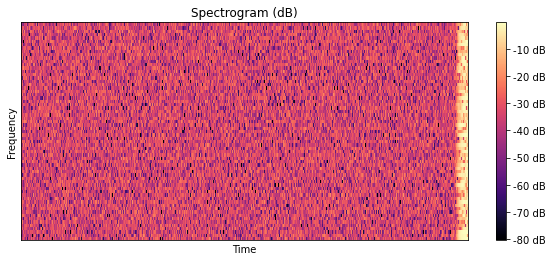

In [40]:
import librosa.display

#magnitude = np.abs(y)
log_spectrogram = librosa.amplitude_to_db(gen_rst[19].T)

plt.figure(figsize=(10,4))
librosa.display.specshow(log_spectrogram, sr=22500, hop_length=128)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

Text(0.5, 1.0, 'Spectrogram (dB)')

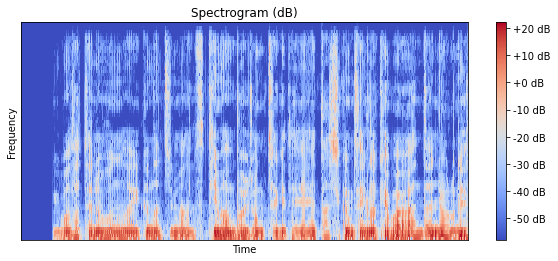

In [43]:
log_spectrogram2 = librosa.amplitude_to_db(stft_data[0].T)

plt.figure(figsize=(10,4))
librosa.display.specshow(log_spectrogram2, sr=22500, hop_length=128)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

In [46]:
test = librosa.griffinlim(stft_data[0].T, hop_length=128, win_length=128)

In [21]:
sf.write('./output1.wav', test, sr, subtype='PCM_24')

NameError: name 'test' is not defined

In [25]:
y, sr = librosa.load('test.wav')
ny = y[:sr*5]

In [33]:
mean = 0
big = 0
small = 0
for i in range(0, len(ny)-1):
    mean = mean+ny[i]
    if(ny[i]>big):
        big = ny[i]
    if(ny[i]<small):
        small = ny[i]
mean = mean/len(ny)
print(mean," ",big," ",small)

1.533906460946131e-05   0.59403914   -0.30628192
